In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as sk
from glove_routines import *
from text_classifier import *
%load_ext autoreload
%autoreload 2

In [4]:
import os
import re

def extrac_param(name):
    params = []
    splited = str(name).split("_")
    for i in range(2,np.shape(splited)[0]):
        p = splited[i]
        value = re.findall(r"[+-]?\d+(?:\.\d+)?",p)
        params.append(float(value[0]))
    return params

def choose_parameters(threshold):
    '''
    Test different parameters to see which one gives the better results.
    '''
    embedding_dim = [5, 30, 50, 100, 200]
    for subdir, dirs, files in os.walk('metadata'):
        size = np.shape(files)[0]
        losses = np.zeros(size)
        names = []
        param = []
        i=0
        for file in files:
            f = np.load('metadata/'+str(file))
            losses[i] = f
            names.append(file)
            param.append(extrac_param(file))
            i+=1
    print(np.shape(names)[0], "results found.")
    smallest_loss=np.ones(201)*pow(10,20)
    smallest_idx = np.zeros(201)
    small_lost = []
    small_idx = []
    small_lost_param = []
    for i in range(0,np.shape(losses)[0]):
        p = param[i]
        emb = p[0]
        loss = losses[i]
        if(loss<smallest_loss[emb]):
            smallest_loss[emb]=loss
            smallest_idx[emb] = int(i)
            
    for i in range(0,np.shape(losses)[0]):
        p = param[i]
        emb = p[0]
        loss = losses[i]
        if(loss<threshold*smallest_loss[emb]):
            small_lost.append(loss)
            small_lost_param.append(p)
            small_idx.append(i)

    print(np.shape(small_lost)[0], "small results found (",threshold,"threshold )")

    for i in embedding_dim:
        cu_params = param[int(smallest_idx[i])]
        print("Smallest lost for embeddings",cu_params[0],"is :",smallest_loss[i],"with params:",cu_params)
        print("   and name:",names[int(smallest_idx[i])])
    i=0
    for a in small_idx:
        p = param[a]
        print("   ",param[a], " loss is ", small_lost[i]/smallest_loss[p[0]])
        i+=1
choose_parameters(1.5)

216 results found.
27 small results found ( 1.5 threshold )
Smallest lost for embeddings 5.0 is : 1202747.60121 with params: [5.0, 0.01, 1.0, 300.0, 1.0]
   and name: embeddings_cost_emb5_eta0.01_alpha1_nmax300_epochs1.npy
Smallest lost for embeddings 30.0 is : 2515917.23658 with params: [30.0, 0.01, 1.0, 300.0, 1.0]
   and name: embeddings_cost_emb30_eta0.01_alpha1_nmax300_epochs1.npy
Smallest lost for embeddings 50.0 is : 3791732.50916 with params: [50.0, 0.01, 1.0, 300.0, 1.0]
   and name: embeddings_cost_emb50_eta0.01_alpha1_nmax300_epochs1.npy
Smallest lost for embeddings 100.0 is : 1e+20 with params: [100.0, 0.01, 0.75, 150.0, 4.0]
   and name: embeddings_cost_emb100_eta0.01_alpha0.75_nmax150_epochs4.npy
Smallest lost for embeddings 100.0 is : 1e+20 with params: [100.0, 0.01, 0.75, 150.0, 4.0]
   and name: embeddings_cost_emb100_eta0.01_alpha0.75_nmax150_epochs4.npy
    [30.0, 0.01, 0.95, 200.0, 1.0]  loss is  1.49471430216
    [30.0, 0.01, 0.95, 250.0, 1.0]  loss is  1.282514913

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
def construct_features(embeddings_file="data/embeddings.npy", flag_save=""):
    '''
    construct a feature representation of each training tweet 
    (by averaging the word vectors over all words of the tweet).
    '''
    #Load the training tweets and the built GloVe word embeddings.
    pos_train = open('data/pos_train.txt').readlines()
    neg_train = open('data/neg_train.txt').readlines()
    embeddings = np.load(embeddings_file)

    
    #count number of word/tweet and store it
    word_nbr_per_tweet_pos = np.zeros(np.shape(pos_train)[0])
    for j in range(0,np.shape(pos_train)[0]):
        tweet = pos_train[j]
        size = len(re.findall(r'\w+', tweet))
        word_nbr_per_tweet_pos[j] = size
        
    word_nbr_per_tweet_neg = np.zeros(np.shape(neg_train)[0])
    for j in range(0,np.shape(neg_train)[0]):
        tweet = neg_train[j]
        size = len(re.findall(r'\w+', tweet))
        word_nbr_per_tweet_neg[j] = size
    
    i=0
    pos_mask = np.zeros(np.shape(embeddings)[1]+1)
    pos_mask[0] +=1
    #adding 1 at start : this is target (1 is for happy emoji, 0 or -1 for sad face)
    training_set_pos = np.zeros(((np.shape(pos_train)[0],np.shape(embeddings)[1]+1))) + pos_mask
    training_set_neg = np.zeros(((np.shape(neg_train)[0],np.shape(embeddings)[1]+1)))
    vocab = open('data/vocab_cut.txt')
    #for each word, search if it is in pos_train or neg_train
    for word_ in vocab:
        word = word_.split("\n")[0]
        current_emb = embeddings[i]
        for j in range(0,np.shape(pos_train)[0]):
            #if yes, add its embeddings.
            if word in pos_train[j]:
                training_set_pos[j,1:np.shape(embeddings)[1]+1] += current_emb
        for j in range(0,np.shape(neg_train)[0]):
            if word in neg_train[j]:
                training_set_neg[j,1:np.shape(embeddings)[1]+1] += current_emb
        i+=1
    #then divide by number of words (averaging word vector over all words of the tweet)
    for i in range(0,np.shape(embeddings)[1]):
        training_set_pos[:,i+1] = training_set_pos[:,i+1]/word_nbr_per_tweet_pos
        training_set_neg[:,i+1] = training_set_neg[:,i+1]/word_nbr_per_tweet_neg
    np.save(str('data/trainingset_pos')+flag_save, training_set_pos)
    np.save(str('data/trainingset_neg')+flag_save, training_set_neg)
    
def test():
     for subdir, dirs, files in os.walk('embeddings'):
        for file in files:
            print(file)
            assert 0==1
            construct_features("embeddings/"+file)
test()

embeddings_emb100_eta0.01_alpha0.75_nmax150_epochs4.npy


AssertionError: 

216 results found.


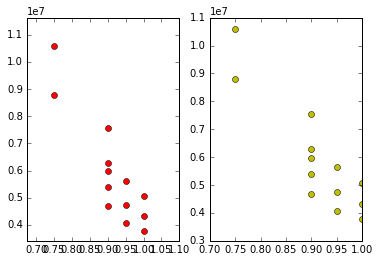

In [110]:
def fix_param(data,idx,value):
    assert ((data[:,idx]==value).any())
    newdata = []
    for i in range(0,np.shape(data)[0]):
        if(data[i,idx]==value):

            newdata.append(data[i])
    #print(newdata)
    return recreate_param(newdata)

def recreate_param(data):
    x = np.shape(data)[0]
    y = np.shape(data)[1]
    param = np.zeros((x,y))
    for i in range(0,x):
        for j in range(0,y):
            param[i,j] = data[i][j]
    return param
from mpl_toolkits.mplot3d import Axes3D
def show_graph():
    embedding_dim = [5, 30, 50, 100, 200]
    for subdir, dirs, files in os.walk('metadata'):
        size = np.shape(files)[0]
        losses = np.zeros(size)
        names = []
        param = []
        i=0
        for file in files:
            f = np.load('metadata/'+str(file))
            losses[i] = f
            names.append(file)
            p = extrac_param(file)
            p.append(f)
            param.append(p)
            i+=1
    print(np.shape(names)[0], "results found.")
    param = recreate_param(param)
    fixed_emb = fix_param(param,0,50)
    fixed_eta = fix_param(fixed_emb,1,0.01)
    xs = fixed_eta[:,2]
    ys = fixed_eta[:,3]
    zs = fixed_eta[:,5]
    plt.figure()
    plt.subplot(121)
    plt.axis([min(xs)-min(xs)/10,max(xs)+max(xs)/10,min(zs)*0.9,max(zs)*1.1])
    plt.plot(xs,zs,'ro')
    plt.subplot(122)
    plt.plot(xs,zs,'yo')
show_graph()